## Importing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

### The Text of the Ṛgveda

In [2]:
df = pd.read_csv("rv.csv")

In [3]:
pattern = r"^b(?P<book>\d{2})_h(?P<hymn>\d{3})_(?P<stanza>\d{2})_zur_(?P<verse>\w)_(?P<word>\w{2})$"
df[['book', 'hymn', 'stanza', 'verse', 'word']] = df['id'].str.extract(pattern, expand=True)

df['book'] = df['book'].astype(int)
df['hymn'] = df['hymn'].astype(int)  
df['stanza'] = df['stanza'].astype(int)
df['word'] = df['word'].astype(int)

df["text_id"] = df["book"].astype(str).str.cat(df["hymn"].astype(str), sep=".")

In [4]:
df = df.set_index("id")

In [5]:
df["morphosyntax"] = df["morphosyntax"].apply(
    lambda x: 
    dict(
        tuple(item.split('=')) 
        for item in x.split('|')
    ) 
    if type(x) is str 
    else dict()
)

### The Metadata to the Ṛgveda

In [6]:
df_strata = pd.read_csv("rv_strata.csv")
pattern = r"^b(?P<book>\d{2})_h(?P<hymn>\d{3})_(?P<stanza>\d{2})_strata_(?P<verse>\w)$"
df_strata[['book', 'hymn', "stanza", "verse"]] = df_strata['id'].str.extract(pattern, expand=True)
for column in ["book", "hymn", "stanza"]: df_strata[column] = df_strata[column].astype(int)
df_strata["text_id"] = df_strata["book"].astype(str).str.cat(df_strata["hymn"].astype(str), sep=".")

In [7]:
df_metadata = pd.read_csv("rv_metadata.csv")
pattern = r"^b(?P<book>\d{2})_h(?P<hymn>\d{3})$"
df_metadata[['book', 'hymn']] = df_metadata['id'].str.extract(pattern, expand=True)
for column in ["book", "hymn"]: df_metadata[column] = df_metadata[column].astype(int)
df_metadata["text_id"] = df_metadata["book"].astype(str).str.cat(df_metadata["hymn"].astype(str), sep=".")
df_metadata["addressee"] = df_metadata["addressee"].str.split(" and |, ", regex=True)
df_metadata = df_metadata.set_index("text_id")

df_metadata["text_length"] = df.groupby("text_id").apply(len)

# use the most frequent = characteristic labels+stratum
df_metadata["stratum"] = df_strata.groupby("text_id")["strata"].apply(lambda x: x.value_counts().index[0])
df_metadata["label"] = df_strata.groupby("text_id")["label"].apply(lambda x: x.value_counts().index[0])

df_metadata

/run/user/1000/ipykernel_1020312/3492873088.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_metadata["text_length"] = df.groupby("text_id").apply(len)


id                   group  \
text_id                                     
1.1      b01_h001  Hymns of Madhucchandas   
1.2      b01_h002  Hymns of Madhucchandas   
1.3      b01_h003  Hymns of Madhucchandas   
1.4      b01_h004  Hymns of Madhucchandas   
1.5      b01_h005  Hymns of Madhucchandas   
...           ...                     ...   
10.187   b10_h187          Hymns of Manyu   
10.188   b10_h188          Hymns of Manyu   
10.189   b10_h189          Hymns of Manyu   
10.190   b10_h190          Hymns of Manyu   
10.191   b10_h191          Hymns of Manyu   

                                        addressee  book  hymn  text_length  \
text_id                                                                      
1.1                                        [Agni]     1     1           89   
1.2            [Vayu, Indra, Vayu, Mitra, Varuna]     1     2           85   
1.3      [Asvins, Indra, All the Gods, Sarasvati]     1     3          108   
1.4                                       [Indra]     1     4          103   
1.5                                       [Indra]     1     5          103   
...                                           ...   ...   ...          ...   
10.187                                     [Agni]    10   187           58   
10.188                           [Agni Jatavedas]    10   188           27   
10.189                                        [?]    10   189           33   
10.190                                    [Tapas]    10   190           36   
10.191                           [Hymn of Unison]    10   191           63   

        stratum label  
text_id                
1.1           N    MO  
1.2           S    MO  
1.3           S    MO  
1.4           s    MO  
1.5           s    MO  
...         ...   ...  
10.187        P     P  
10.188        C     M  
10.189        P     P  
10.190        P  PE3a  
10.191        P   PE2  

[1028 rows x 8 columns]

In [18]:
df_metadata["addressee"].explode().value_counts()

addressee
Indra                  283
Agni                   195
Soma                   126
All the Gods            64
Asvins                  55
                      ... 
Bhaga                    1
Vasistha                 1
Blessing of Weapons      1
Others                   1
Hymn of Unison           1
Name: count, Length: 159, dtype: int64

#### Joining Metadata and Text

In [21]:
df = df.merge(
    df_metadata[["group", "addressee", "text_length", "stratum", "label"]],
    on="text_id"
)

In [22]:
df["grammar"].value_counts()

grammar
nominal stem    86864
root            32000
invariable      25902
pronoun         19997
Name: count, dtype: int64

In [23]:
pd.crosstab(df_metadata["book"], df_metadata["stratum"])

stratum   A   C   N   P   S  a  c   n  p   s
book                                        
1        28  44  32  10  34  9  1  14  1  18
2         4   5  31   2   1  0  0   0  0   0
3         0   5  41   1   0  0  4   0  2   9
4         0   0  27   2  28  0  0   0  1   0
5        42  23  17   3   0  0  0   0  0   2
6        43  20   0   3   0  0  3   6  0   0
7         0  26   0   5  66  0  2   3  2   0
8        42   0   1   3  53  0  0   2  2   0
9        13   1  89   3   8  0  0   0  0   0
10       22  51  11  90  11  0  0   2  3   1

In [27]:
df = df[df["addressee"].apply(lambda xs: "Soma" in xs)]


In [28]:
df = df[df["grammar"].isin({"nominal stem"}) & df["morphosyntax"]]
text_ids = df["text_id"].unique()
corpus = df.groupby("text_id")["lemmaId"].apply(lambda x: " ".join(str(word).replace("#lemma_","") for word in x))

vectorizer = TfidfVectorizer(
    input="content", lowercase=False, analyzer="word",
    token_pattern=r"(?u)\b\w+_\d+\b", ngram_range=(1,1),
    max_df=1.0, min_df=1, max_features=None, stop_words=[] # do not count words if they appear at least in half of the hymns
)
counts = vectorizer.fit_transform(corpus.tolist()).toarray()
counts_df = pd.DataFrame(counts, index=corpus.index, columns=vectorizer.get_feature_names_out())

In [29]:
df[df["text_id"] == "10.127"]


Empty DataFrame
Columns: [surface, lemma, lemmaId, grammar, morphosyntax, book, hymn, stanza, verse, word, text_id, group, addressee, text_length, stratum, label]
Index: []

In [30]:
" ".join(df[df["text_id"] == "10.127"]["surface"])

''

In [31]:
ratri = counts_df.loc["10.127"].sort_values(ascending=False)
ratri[ratri > 0].head(10)

KeyError: '10.127'

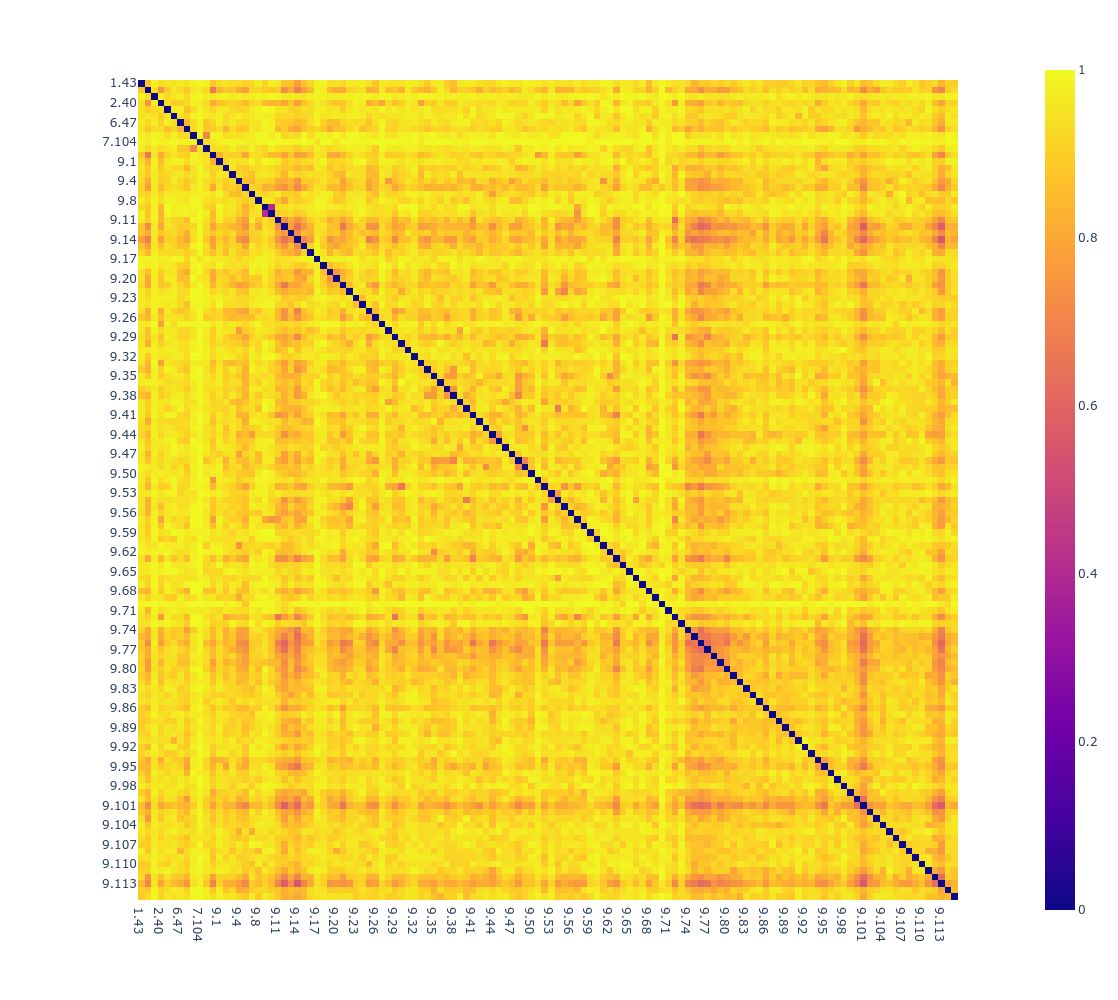

In [32]:
distances = pd.DataFrame(squareform(pdist(counts, metric="cosine")), index=text_ids, columns=text_ids)

distance_figure = px.imshow(distances)
distance_figure.update_layout(
    autosize=False,
    width=1000,
    height=1000,
)
distance_figure.show()

In [33]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, to_hex

top_n = 3
filtered_edges = []
for text in distances.index:
    top_similarities = distances[text].nsmallest(top_n + 1).iloc[1:]
    for similar_text, similarity in top_similarities.items():
        filtered_edges.append((text, similar_text, similarity))

filtered_edges

[('1.43', '9.14', 0.7775531897625175),
 ('1.43', '9.75', 0.8377269712324368),
 ('1.43', '9.113', 0.840820482232991),
 ('1.91', '8.79', 0.6648032675952056),
 ('1.91', '9.14', 0.6829118149385602),
 ('1.91', '9.113', 0.7038879659670216),
 ('1.93', '4.27', 0.9246669834133645),
 ('1.93', '6.72', 0.9289413962853244),
 ('1.93', '1.91', 0.9329136826983895),
 ('2.40', '1.91', 0.7548826211124184),
 ('2.40', '9.72', 0.7699069980759413),
 ('2.40', '9.14', 0.7732234773764258),
 ('4.27', '9.101', 0.847653547841876),
 ('4.27', '6.72', 0.8643320056249648),
 ('4.27', '9.76', 0.8812676094851044),
 ('4.28', '9.91', 0.8353489309317828),
 ('4.28', '9.113', 0.8473528916078823),
 ('4.28', '9.101', 0.872004845933105),
 ('6.47', '9.113', 0.8220332666072652),
 ('6.47', '9.108', 0.8361800297871498),
 ('6.47', '6.72', 0.8420279064111519),
 ('6.72', '9.113', 0.750661203197432),
 ('6.72', '9.100', 0.7586571223666931),
 ('6.72', '9.74', 0.7797399586504713),
 ('6.74', '8.48', 0.7115780431721225),
 ('6.74', '9.101', 0

In [34]:
G = nx.Graph()
for text, similar_text, similarity in filtered_edges:
    G.add_edge(text, similar_text, weight=similarity)

In [35]:
G.number_of_nodes(), G.number_of_edges()

(126, 345)

In [36]:
import numpy as np
np.array([d for n, d in G.degree()]).mean()

5.476190476190476

In [37]:
nx.degree_centrality(G)

{'1.43': 0.024,
 '9.14': 0.248,
 '9.75': 0.10400000000000001,
 '9.113': 0.376,
 '1.91': 0.07200000000000001,
 '8.79': 0.032,
 '1.93': 0.024,
 '4.27': 0.032,
 '6.72': 0.064,
 '2.40': 0.04,
 '9.72': 0.08,
 '9.101': 0.424,
 '9.76': 0.312,
 '4.28': 0.024,
 '9.91': 0.024,
 '6.47': 0.024,
 '9.108': 0.04,
 '9.100': 0.04,
 '9.74': 0.07200000000000001,
 '6.74': 0.024,
 '8.48': 0.032,
 '7.104': 0.024,
 '9.17': 0.032,
 '9.106': 0.032,
 '9.68': 0.032,
 '9.51': 0.024,
 '9.1': 0.024,
 '9.94': 0.04,
 '9.2': 0.024,
 '9.95': 0.04,
 '9.3': 0.024,
 '9.77': 0.10400000000000001,
 '9.4': 0.056,
 '9.61': 0.024,
 '9.6': 0.056,
 '9.7': 0.024,
 '9.44': 0.056,
 '9.105': 0.024,
 '9.8': 0.024,
 '9.12': 0.2,
 '9.9': 0.024,
 '9.10': 0.024,
 '9.57': 0.04,
 '9.11': 0.04,
 '9.13': 0.032,
 '9.15': 0.032,
 '9.16': 0.024,
 '9.28': 0.032,
 '9.81': 0.04,
 '9.18': 0.024,
 '9.19': 0.032,
 '9.20': 0.032,
 '9.21': 0.04,
 '9.22': 0.024,
 '9.55': 0.024,
 '9.52': 0.064,
 '9.23': 0.024,
 '9.24': 0.024,
 '9.78': 0.04,
 '9.36': 0.032

In [38]:
# Create a DataFrame with 'text' and 'degree' from the graph G
degrees = pd.DataFrame({"text": n, "degree": d} for n, d in G.degree())

# Set 'text' as the index for the degrees DataFrame
degrees.set_index("text", inplace=True)

# Merge degrees DataFrame with df_metadata on their indices
texts_with_degrees = df_metadata.merge(degrees, left_index=True, right_index=True, how="left")

# Add the 'degree' column to df_metadata
df_metadata['degree'] = texts_with_degrees['degree']

In [39]:
df_metadata["betweenness_centrality"] = nx.betweenness_centrality(G)

In [40]:
df_metadata.sort_values(by="betweenness_centrality", ascending=False)

id                    group         addressee  book  hymn  \
text_id                                                                    
9.101    b09_h101       The Anustubh-Group            [Soma]     9   101   
9.113    b09_h113           Various Metres            [Soma]     9   113   
9.76     b09_h076         The Jagati Group            [Soma]     9    76   
9.14     b09_h014  Tirasci and Other Poets            [Soma]     9    14   
9.12     b09_h012  Tirasci and Other Poets            [Soma]     9    12   
...           ...                      ...               ...   ...   ...   
10.187   b10_h187           Hymns of Manyu            [Agni]    10   187   
10.188   b10_h188           Hymns of Manyu  [Agni Jatavedas]    10   188   
10.189   b10_h189           Hymns of Manyu               [?]    10   189   
10.190   b10_h190           Hymns of Manyu           [Tapas]    10   190   
10.191   b10_h191           Hymns of Manyu  [Hymn of Unison]    10   191   

         text_length stratum label  degree  betweenness_centrality  
text_id                                                             
9.101            195       A     M    53.0                0.294075  
9.113            193       P   PE1    47.0                0.267752  
9.76              90       S     M    39.0                0.221329  
9.14              79       N    MO    31.0                0.152280  
9.12              85       N    MO    25.0                0.075707  
...              ...     ...   ...     ...                     ...  
10.187            58       P     P     NaN                     NaN  
10.188            27       C     M     NaN                     NaN  
10.189            33       P     P     NaN                     NaN  
10.190            36       P  PE3a     NaN                     NaN  
10.191            63       P   PE2     NaN                     NaN  

[1028 rows x 10 columns]

<Axes: xlabel='degree', ylabel='betweenness_centrality'>

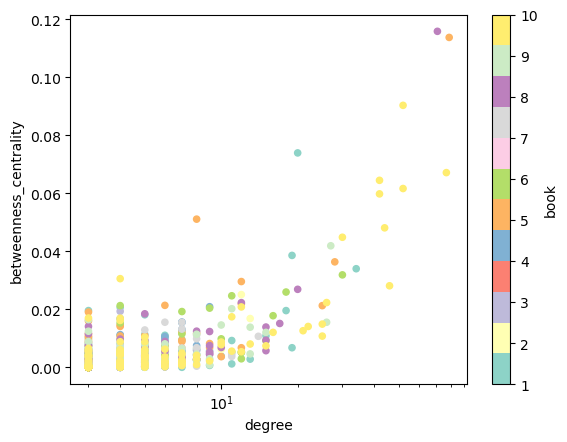

In [94]:
df_metadata.plot.scatter(x="degree", y="betweenness_centrality", c="book", colormap="Set3", logx=True)

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

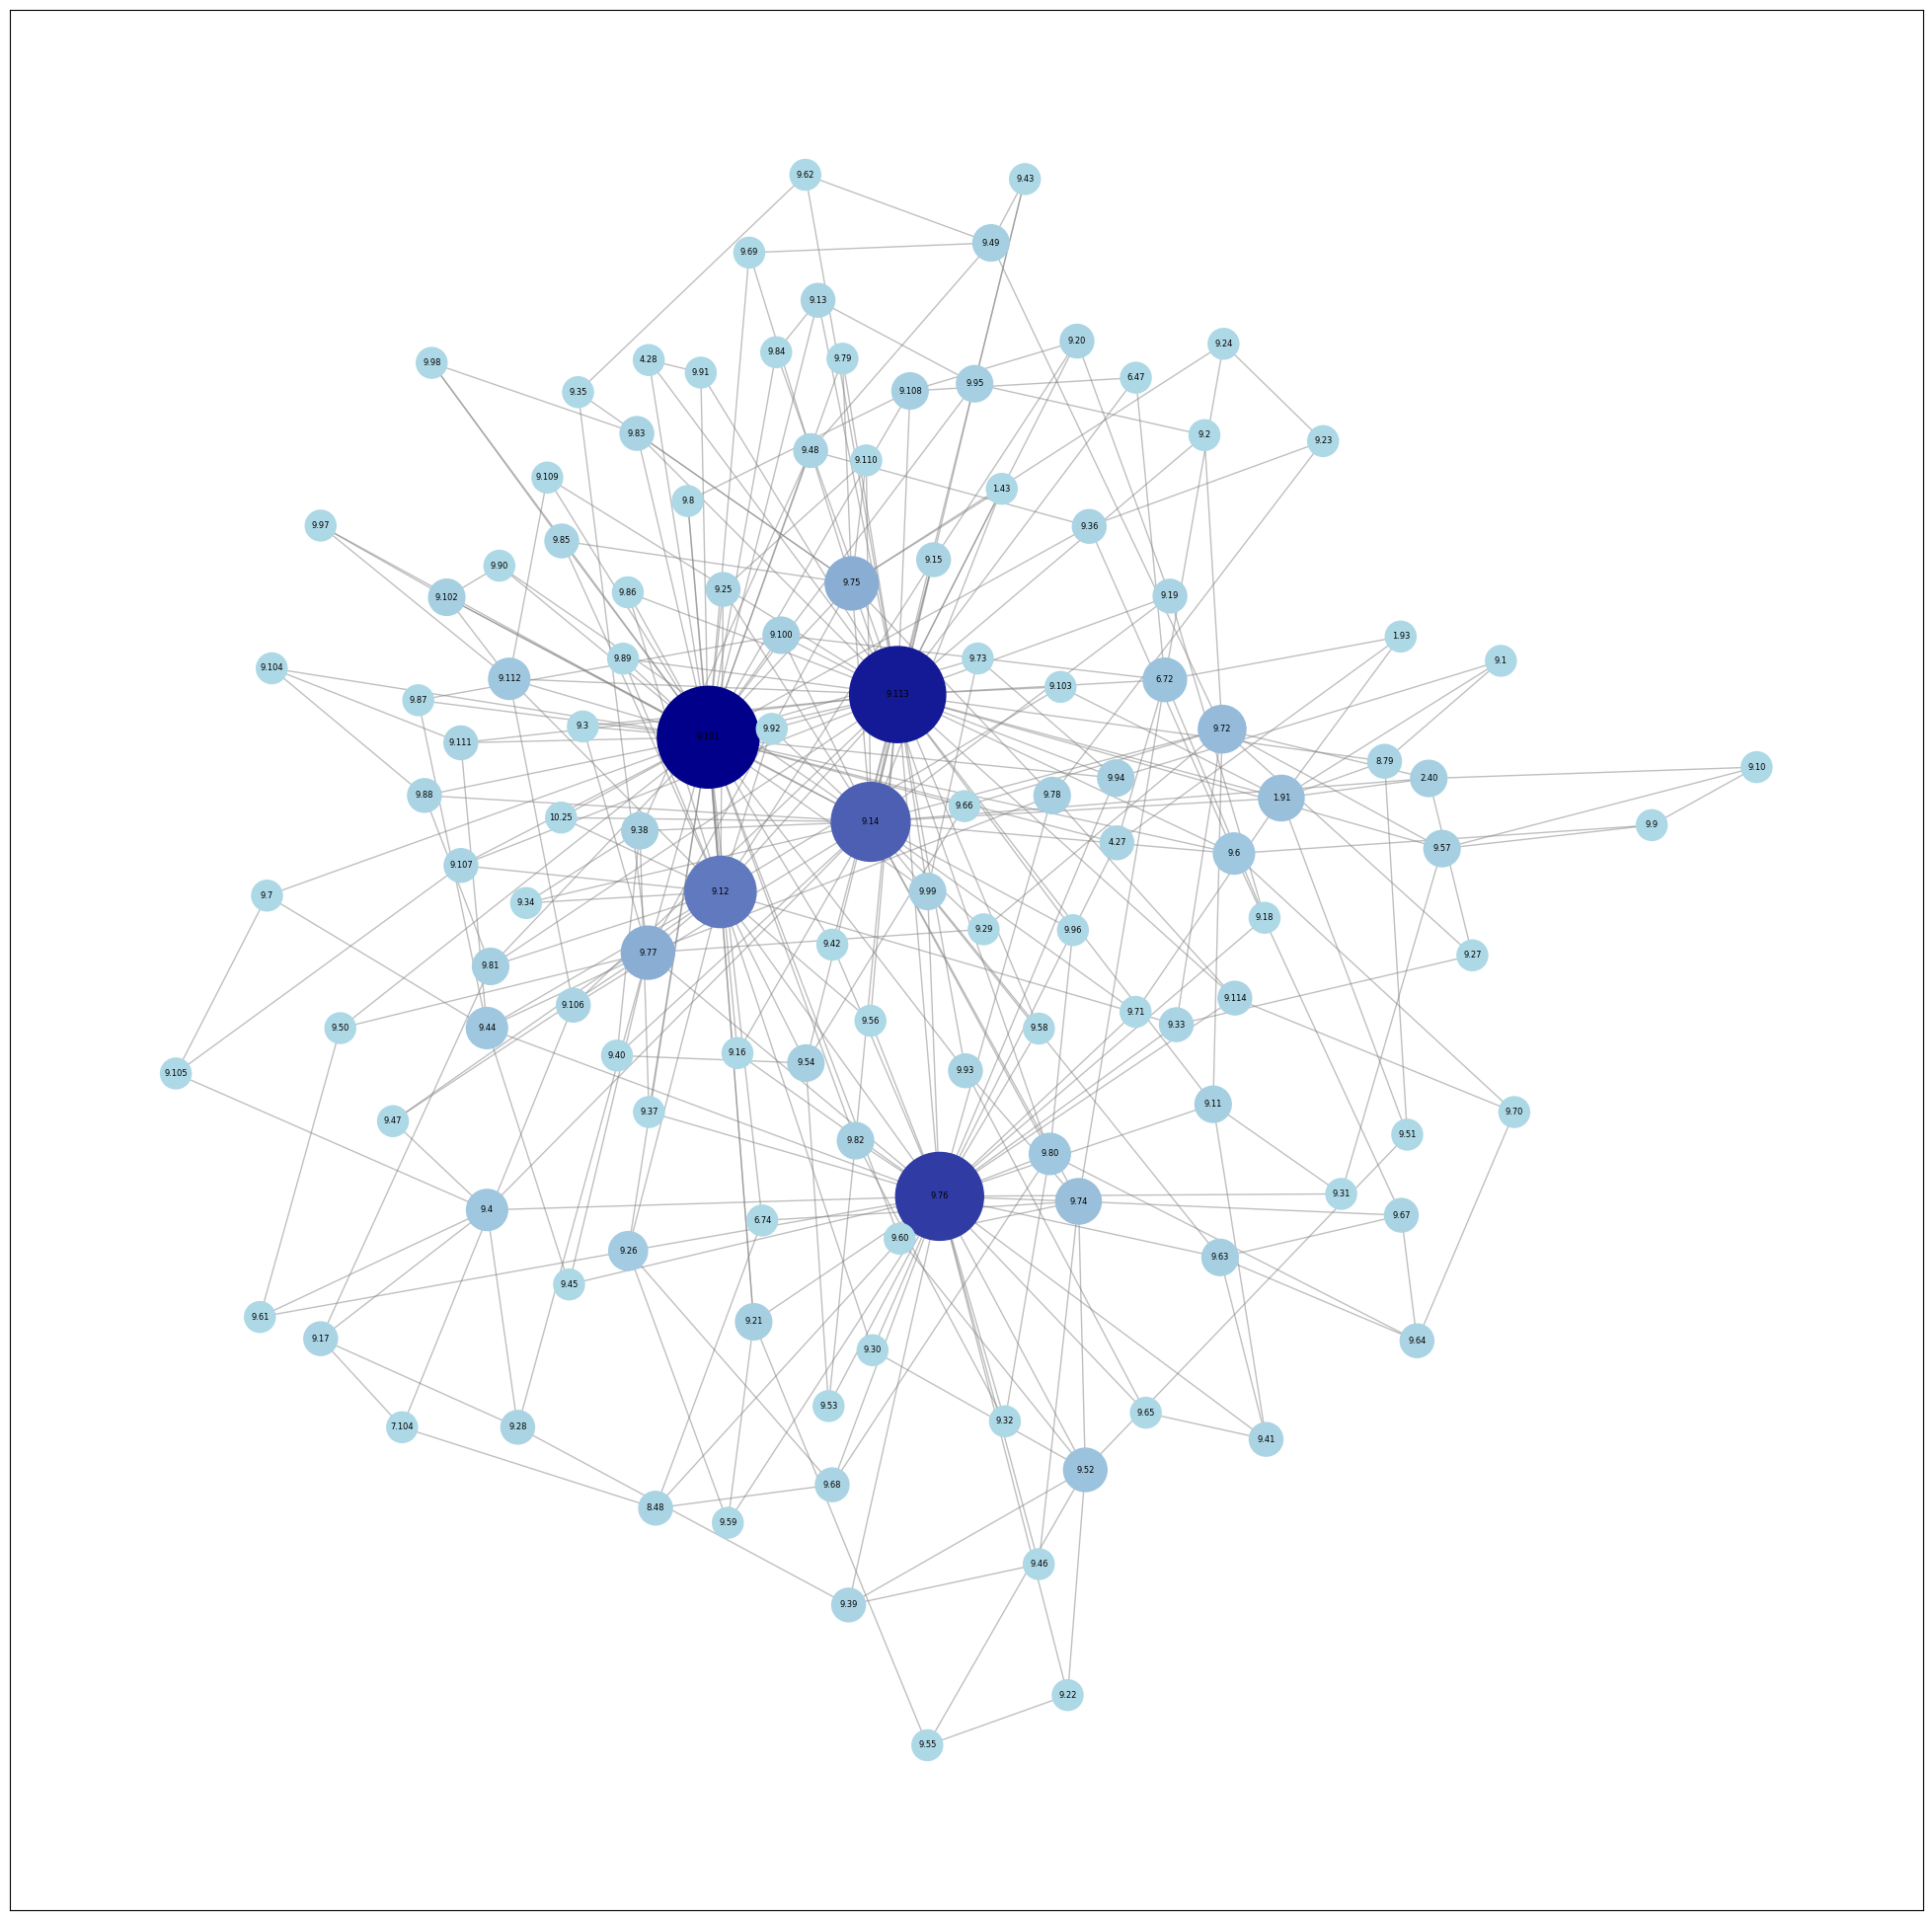

In [41]:
plt.figure(figsize=(25, 25))
pos = nx.spring_layout(G, seed=42, k=10, iterations=5000, weight="weight")
degrees = dict(G.degree())
node_sizes = [200 + 100 * degrees[n] for n in G.nodes()]
max_degree = max(degrees.values())
node_colors = [degrees[n] / max_degree for n in G.nodes()]
monochrome_cmap = LinearSegmentedColormap.from_list("monochrome_blue", ["lightblue", "darkblue"])
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap=monochrome_cmap)
edges = G.edges(data=True)
weights = [1 / (edge[2]["weight"] * 2) if edge[2]["weight"] != 0 else 0 for edge in edges]
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color="gray", alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=6, font_family="sans-serif")
sm = plt.cm.ScalarMappable(cmap=monochrome_cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm)
plt.title("Network Visualization of Texts Based on Cosine Similarity of TF-IDF")
plt.show()

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

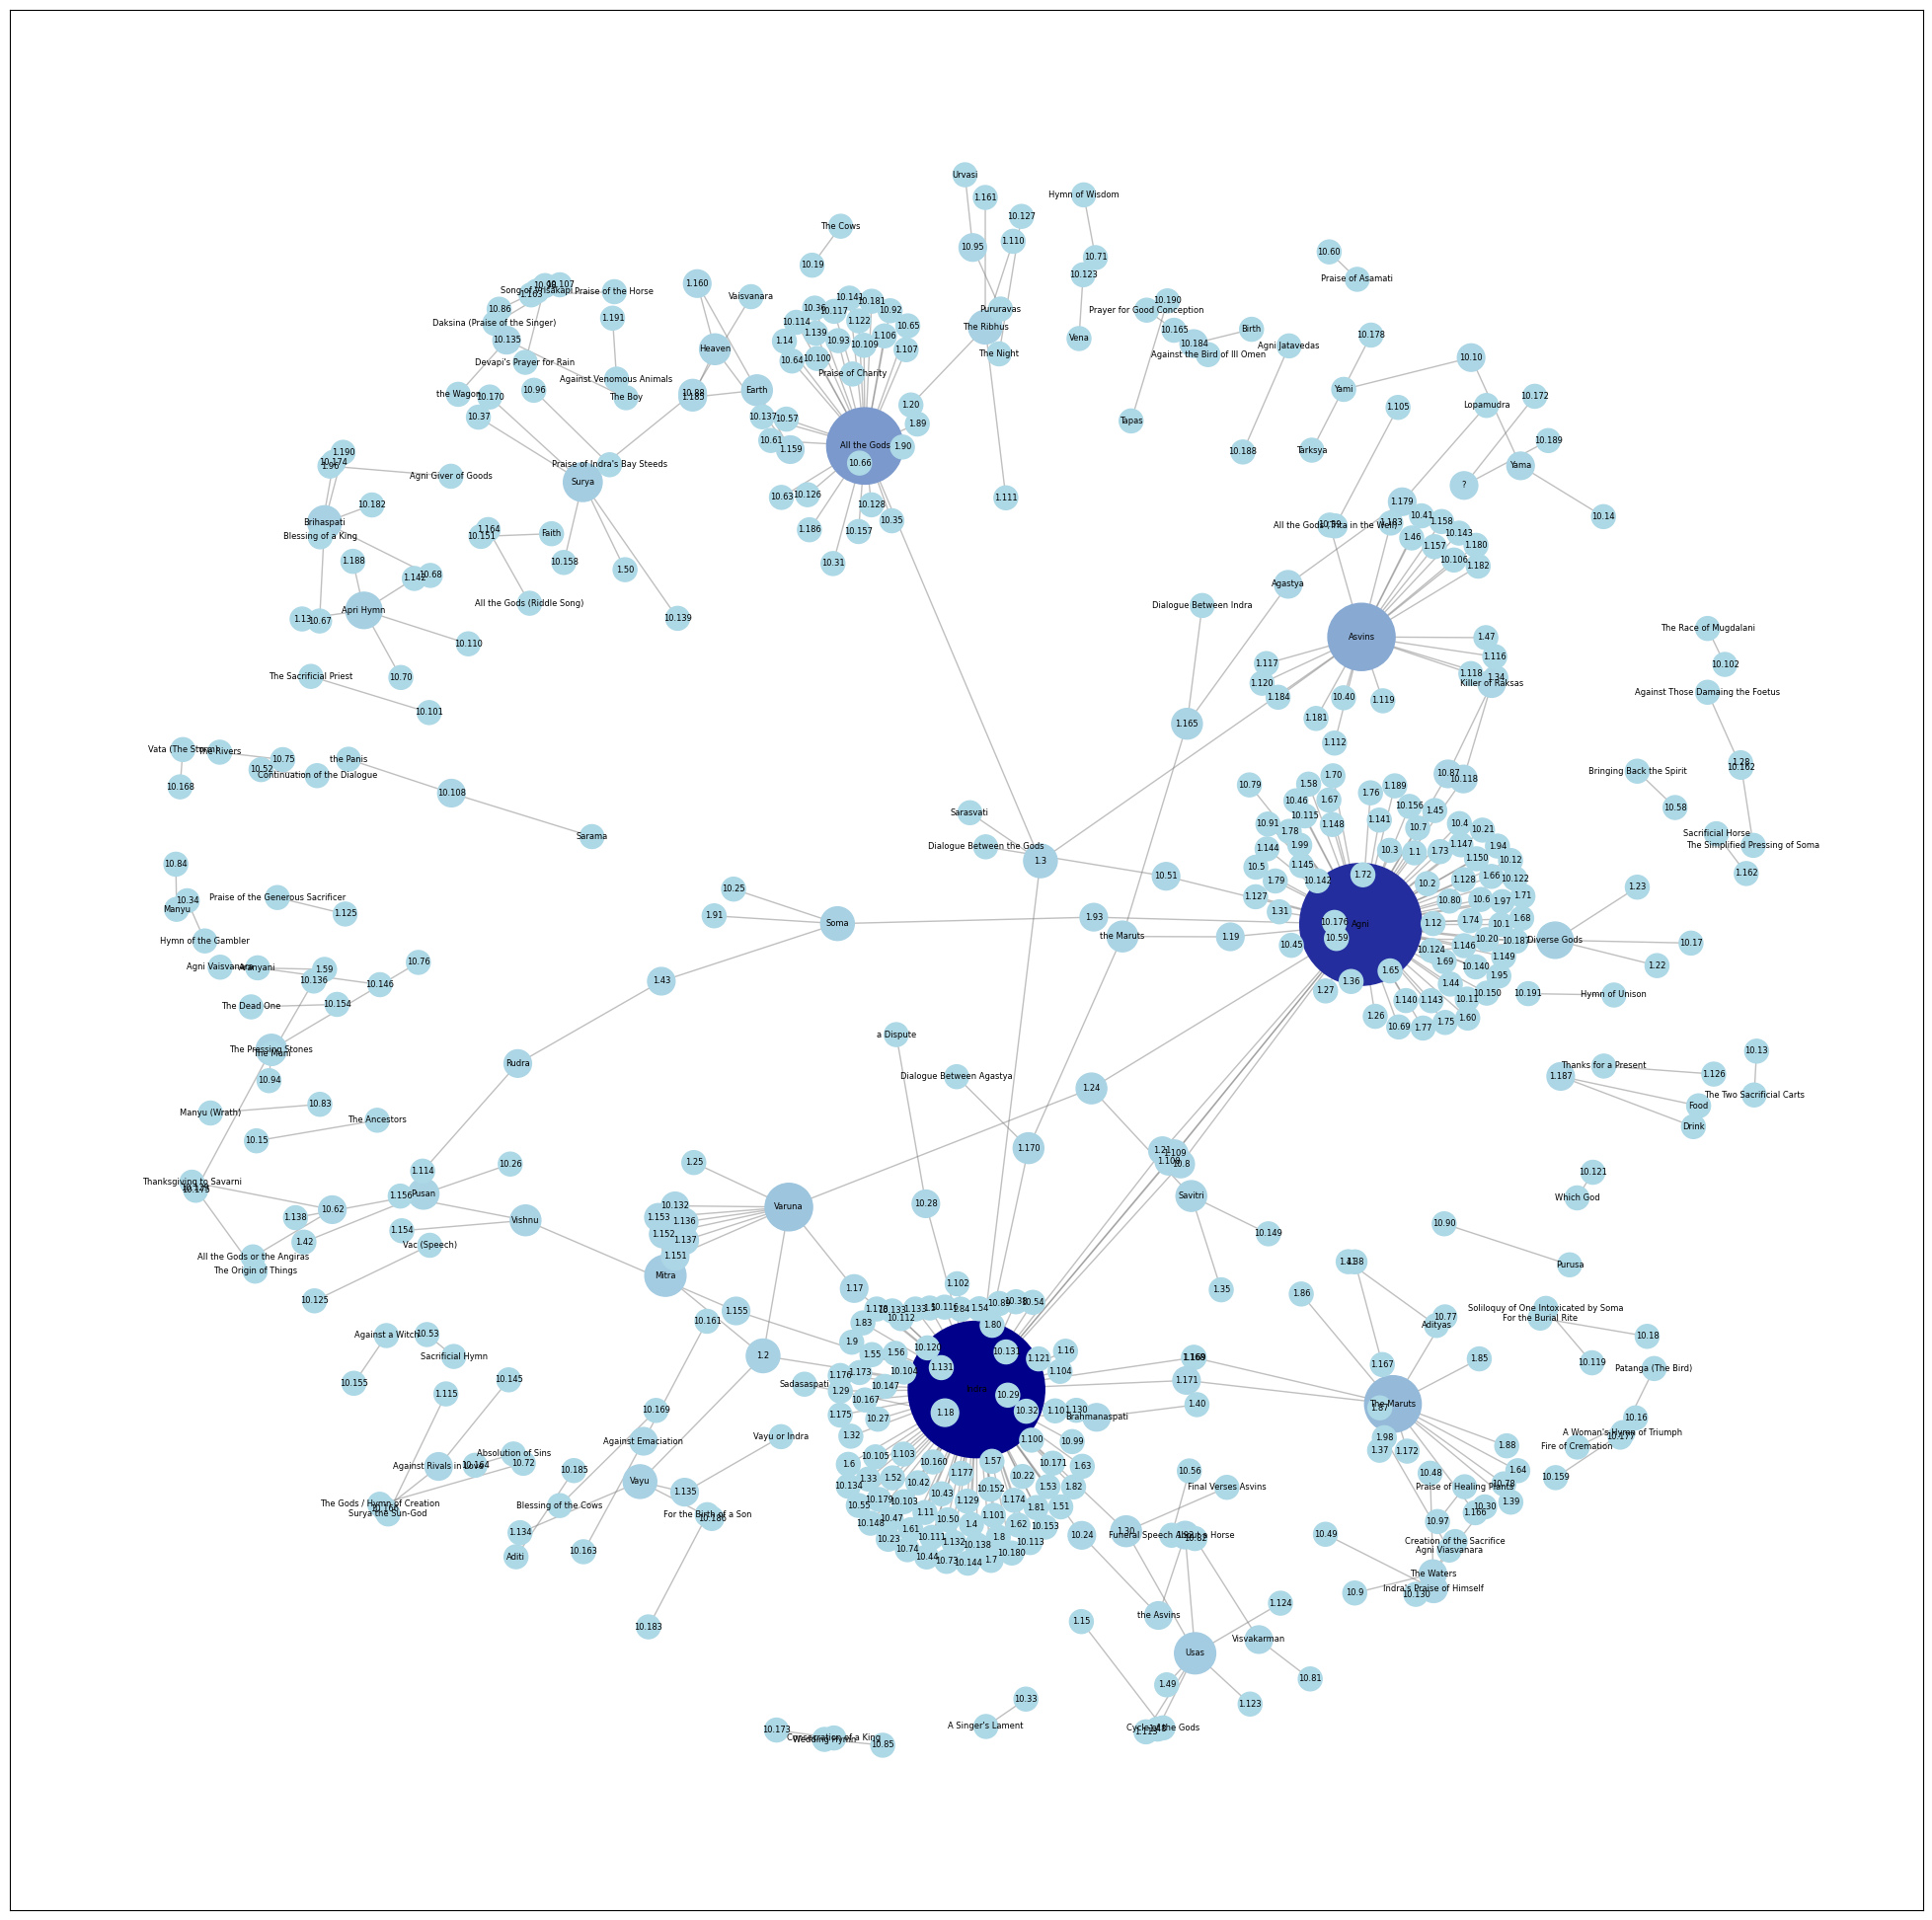

In [31]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, to_hex

top_n = 3
filtered_edges = []
G = nx.Graph()
for text in df_metadata.index:
    if text.startswith("10.") or text.startswith("1."):
        for addressee in df_metadata.loc[text]["addressee"]:
            G.add_edge(text, addressee)

G

plt.figure(figsize=(25, 25))
pos = nx.spring_layout(G, seed=42, k=10, iterations=5000)
degrees = dict(G.degree())
node_sizes = [200 + 100 * degrees[n] for n in G.nodes()]
max_degree = max(degrees.values())
node_colors = [degrees[n] / max_degree for n in G.nodes()]
monochrome_cmap = LinearSegmentedColormap.from_list("monochrome_blue", ["lightblue", "darkblue"])
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap=monochrome_cmap)
edges = G.edges(data=True)
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color="gray", alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=6, font_family="sans-serif")
sm = plt.cm.ScalarMappable(cmap=monochrome_cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm)
plt.title("Network Visualization of Texts Based on Cosine Similarity of TF-IDF")
plt.show()

In [42]:
tsne = TSNE(
    n_components=2, 
    perplexity=distances.shape[0]**0.5, 
    n_iter=5000, 
    metric="cosine", 
    init="pca"
)
reduced_data = tsne.fit_transform(distances)
reduced_df = pd.DataFrame(data=reduced_data, index=text_ids, columns=["component 1", "component 2"])
reduced_df_metadata = df_metadata.join(reduced_df, on="text_id")

In [43]:
reduced_df_metadata

id                   group  \
text_id                                     
1.1      b01_h001  Hymns of Madhucchandas   
1.2      b01_h002  Hymns of Madhucchandas   
1.3      b01_h003  Hymns of Madhucchandas   
1.4      b01_h004  Hymns of Madhucchandas   
1.5      b01_h005  Hymns of Madhucchandas   
...           ...                     ...   
10.187   b10_h187          Hymns of Manyu   
10.188   b10_h188          Hymns of Manyu   
10.189   b10_h189          Hymns of Manyu   
10.190   b10_h190          Hymns of Manyu   
10.191   b10_h191          Hymns of Manyu   

                                        addressee  book  hymn  text_length  \
text_id                                                                      
1.1                                        [Agni]     1     1           89   
1.2            [Vayu, Indra, Vayu, Mitra, Varuna]     1     2           85   
1.3      [Asvins, Indra, All the Gods, Sarasvati]     1     3          108   
1.4                                       [Indra]     1     4          103   
1.5                                       [Indra]     1     5          103   
...                                           ...   ...   ...          ...   
10.187                                     [Agni]    10   187           58   
10.188                           [Agni Jatavedas]    10   188           27   
10.189                                        [?]    10   189           33   
10.190                                    [Tapas]    10   190           36   
10.191                           [Hymn of Unison]    10   191           63   

        stratum label  degree  betweenness_centrality  component 1  \
text_id                                                              
1.1           N    MO     NaN                     NaN          NaN   
1.2           S    MO     NaN                     NaN          NaN   
1.3           S    MO     NaN                     NaN          NaN   
1.4           s    MO     NaN                     NaN          NaN   
1.5           s    MO     NaN                     NaN          NaN   
...         ...   ...     ...                     ...          ...   
10.187        P     P     NaN                     NaN          NaN   
10.188        C     M     NaN                     NaN          NaN   
10.189        P     P     NaN                     NaN          NaN   
10.190        P  PE3a     NaN                     NaN          NaN   
10.191        P   PE2     NaN                     NaN          NaN   

         component 2  
text_id               
1.1              NaN  
1.2              NaN  
1.3              NaN  
1.4              NaN  
1.5              NaN  
...              ...  
10.187           NaN  
10.188           NaN  
10.189           NaN  
10.190           NaN  
10.191           NaN  

[1028 rows x 12 columns]

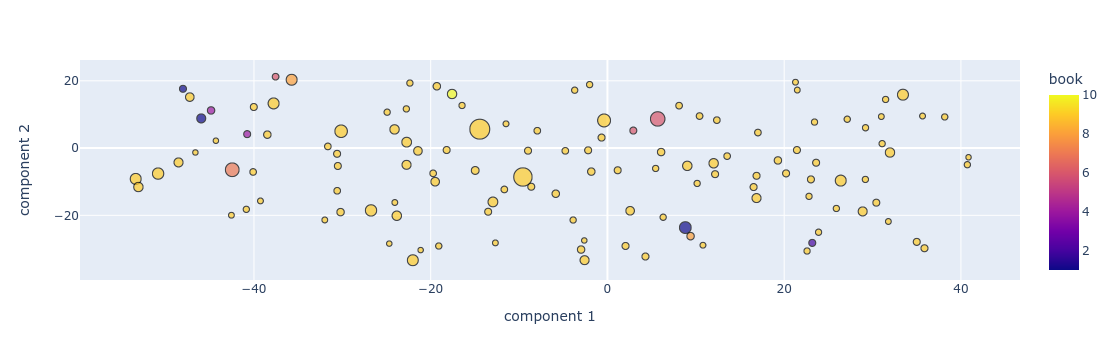

In [44]:
size_min = 3
size_max = 70
size = (reduced_df_metadata["text_length"] / reduced_df_metadata["text_length"].max() * (size_max - size_min) + size_min).tolist()

fig = px.scatter(reduced_df_metadata, x="component 1", y="component 2", size=size, color="book", hover_data=["addressee", "group", "label", "stratum", "book", "hymn", "text_length", reduced_df_metadata.index])
fig.update_traces(marker=dict(line=dict(width=1, color='black')))
fig.show()